In [1]:
import pandas as pd
import sys
import Levenshtein
from  textprepare import TextColumnPrepare
from Levenshtein import *
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Total length 28588505

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
TOTAL_LEN = 28588505
def readedits(fileerror, filecorrect, id_from=0, id_to=0, col_prep=TextColumnPrepare(), read_all=False):
    if read_all == False:
        data = []
        with open(fileerror, 'r') as erf:
            with open(filecorrect, 'r') as cor:
                i = 0
                while i < id_to:
                    if i >= id_from:
                        data.append([col_prep.prepare_string(erf.readline()), 
                                     col_prep.prepare_string(cor.readline())])
                    else:
                        erf.readline()
                        cof.readline()
                    i +=1
    else:
        data = []
        with open(fileerror, 'r') as erf:
            with open(filecorrect, 'r') as cor:
                l_er = erf.readlines()
                l_co = cor.readlines()
                for ers, cos in tqdm(zip(l_er, l_co)):
                    data.append([col_prep.prepare_string(ers), col_prep.prepare_string(cos)])
    return data

In [13]:
%%time
data = readedits('wiked.tok.err', 'wiked.tok.cor', 0, TOTAL_LEN, read_all=True)

28588505it [2:59:54, 2648.34it/s]

CPU times: user 2h 52min 59s, sys: 8min 19s, total: 3h 1min 18s
Wall time: 3h 23s


In [ ]:
data[150]

In [ ]:
# SAVE!!!

In [14]:
pickle.dump(data, open( "read_data.p", "wb" ))

README.md    requirements.txt  wiked-v1.0.en.prepro.tgz
__pycache__  tests.ipynb       wiked.tok.cor
read_data.p  textprepare.py    wiked.tok.err


In [2]:
data = pickle.load( open( "read_data.p", "rb" ) )

In [3]:
lens = np.zeros((15,))
# Collect distribution of lengths of words.
for pair in tqdm(data):
    for word in pair[0].split():
        l = len(word)
        if l < 15:
            lens[l] += 1

100%|██████████| 28588505/28588505 [04:18<00:00, 110550.10it/s]


No handles with labels found to put in legend.


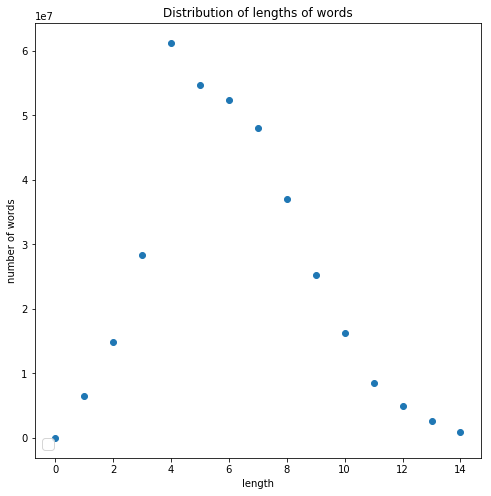

In [4]:
plt.figure(figsize=(8,8))
plt.title("Distribution of lengths of words")
plt.scatter(np.arange(0,15), lens)
plt.xlabel(r'length')
plt.ylabel(r'number of words')
plt.legend(fontsize=15,loc=3)
plt.show()

In [28]:
del data

In [9]:
editops('setingss', 'something')

[('insert', 1, 1),
 ('insert', 1, 2),
 ('insert', 3, 5),
 ('delete', 6, 9),
 ('delete', 7, 9)]

In [19]:
def get_statistis_words(data, max_distance=3):
    res_words = []
    for i, line in tqdm(enumerate(data)):
        errsent = line[0].split()
        corsent = line[1].split()
        for errw in errsent:
            for corw in corsent:
                # Remove small words
                if (len(errw) < 2) or (len(corw) < 2):
                    continue
                # Remove digits
                if errw.isdigit() or corw.isdigit():
                    continue
                # Distance from Levenstein
                d = distance(errw, corw) 
                if (d > 0) and d < max_distance:
                    res_words.append([errw, corw])
    return res_words

In [20]:
pairs = get_statistis_words(data)

28588505it [1:05:37, 7261.11it/s]


In [21]:
pickle.dump(pairs, open('pairs.p', 'wb'))

In [5]:
pairs = pickle.load( open( "pairs.p", "rb" ) )

In [6]:
# Collect distribution of lengths of words with typos.
typo_lens = np.zeros((15,))
for pair in tqdm(pairs):
    l = len(pair[0])
    if l < 15:
        typo_lens[l] += 1

100%|██████████| 47927404/47927404 [00:44<00:00, 1081648.82it/s]


No handles with labels found to put in legend.


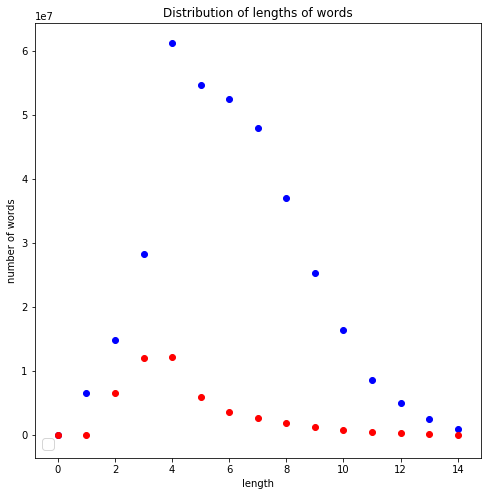

In [7]:
plt.figure(figsize=(8,8))
plt.title("Distribution of lengths of words")
plt.scatter(np.arange(0,15), lens, c='b')
plt.scatter(np.arange(0,15), typo_lens, c='r')
plt.xlabel(r'length')
plt.ylabel(r'number of words')
plt.legend(fontsize=15,loc=3)
plt.show()

In [8]:
del lens
del typo_lens

In [9]:
import gc
gc.collect()

2409

### Что интересно: 
    1) С какой вероятностью делать dropout буквы?
    2) С какой вероятностью делать insert буквы?
    3) Как распределены опечатки по длине?
    4) Как удобно делать embedding-и устойчивые к опечаткам?
    5) Как можно это применять к char алгоритмам?

In [9]:
def collect_statistics(pairs):
    less_5 = []
    longer_5 = []
    for pair in tqdm(pairs):
        # Set equal length
        l1 = len(pair[0])
        l2 = len(pair[1])
        dif = l1 - l2
        if dif > 0:
            for i in range(dif):
                pair[1]+= '0'
        if dif < 0:
            for i in range(abs(dif)):
                pair[0] += '0'
                
        if l1 < 5 and l2 < 5:
            for j, s in enumerate(pair[0]):
                if s != pair[1][j]:
                    less_5.append(j)
        else:
            for j, s in enumerate(pair[0]):
                if s != pair[1][j]:
                    longer_5.append(j)
    return less_5, longer_5

In [10]:
def collect_complex_statistics(pairs):
    """
    Parameters
    
    pairs: list of pairs,
        first element with errors, second element is correct.
    
    Return
    statistic: list of info 
        index 0: ind
        index 1: length of correct word
        index 2: 0 - delete 1- insert
        index 3: position of edit
    """
    statistic = []
    for i, pair in tqdm(enumerate(pairs)):
        l1 = len(pair[0])
        l2 = len(pair[1])
        edit_seq = editops(pair[0], pair[1])
        for edit in edit_seq:
            if edit[0] == 'delete':
                statistic.append([i, l2, 0, edit[1]])
            if edit[0] == 'insert':
                statistic.append([i, l2, 1, edit[1]])
    return statistic

In [11]:
complex_statistic = collect_complex_statistics(pairs)

47927404it [01:27, 546926.69it/s]


In [13]:
del data

In [14]:
del pairs

In [15]:
complex_statistic = np.array(complex_statistic)

In [16]:
complex_statistic.shape

(31661411, 4)

In [18]:
insert = complex_statistic[np.where(complex_statistic[:, 2] == 1)]

In [20]:
insert_dist = insert[:, 3]

Text(0.5,1,'Dropout distribution')

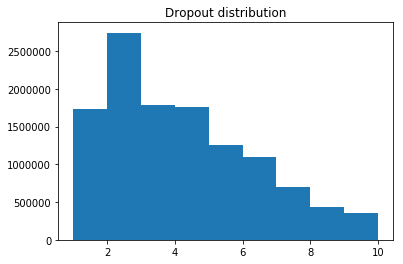

In [36]:
# For dropout
plt.hist(insert_dist, bins=np.arange(1,11))
plt.title("Dropout distribution")

In [29]:
delete = complex_statistic[np.where(complex_statistic[:, 2] == 0)]

In [30]:
delete_dist = delete[:, 3]

Text(0.5,1,'Insert distribution')

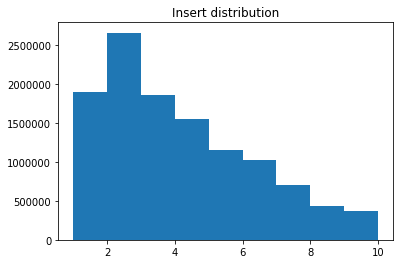

In [35]:
# For insert
plt.hist(delete_dist, bins=np.arange(1,11))
plt.title("Insert distribution")

Text(0.5,1,'Typo words length distribution')

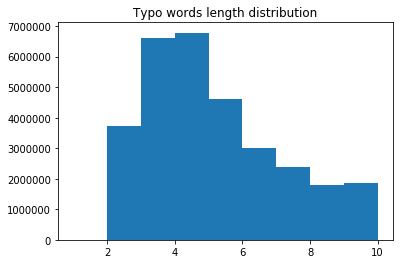

In [33]:
plt.hist(complex_statistic[:, 1], bins=np.arange(1,11))
plt.title("Typo words length distribution")

In [10]:
less_5, longer_5 = collect_statistics(pairs)

100%|██████████| 47927404/47927404 [02:04<00:00, 384891.94it/s]


In [31]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [37]:
h1 = np.histogram(less_5, bins=4)
h2 = np.histogram(longer_5, bins=5)

In [41]:
h2

(array([50232487,      344,       78,       15,        3]),
 array([   0. ,   31.8,   63.6,   95.4,  127.2,  159. ]))

(array([ 19351456.,         0.,         0.,  16990217.,         0.,
                0.,  17088530.,         0.,         0.,   9168959.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

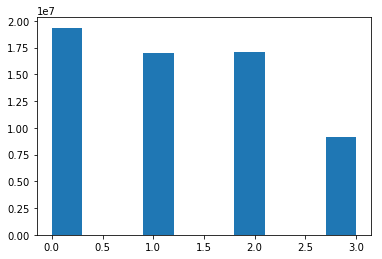

In [34]:
plt.hist(less_5)

(array([ 4145208.,  5779184.,  6665539.,  9363600.,  6025362.,  4820540.,
         3466172.,  2297860.,  2204960.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 9 Patch objects>)

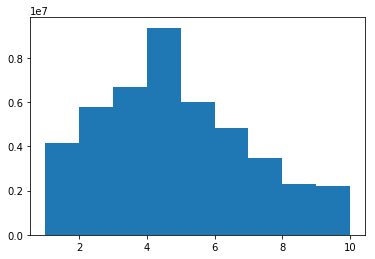

In [43]:
plt.hist(longer_5, bins=[1,2,3,4,5,6,7,8,9,10])

In [50]:
bins = [1,2,3,4,5,6,7,8,9,10]

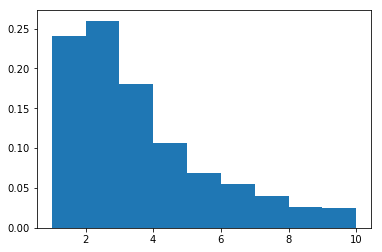

In [57]:
val = plt.hist(less_5 + longer_5, bins=[1,2,3,4,5,6,7,8,9,10], normed=True)

In [45]:
mean = np.mean(less_5 + longer_5)

In [46]:
mean

2.5162076809550165

In [47]:
from scipy.stats import poisson

In [53]:
pois_pmf = poisson.pmf(bins, mean)

In [63]:
val[0]

array([ 0.24013127,  0.25981276,  0.1799045 ,  0.10638504,  0.06845747,
        0.05476882,  0.0393811 ,  0.02610726,  0.02505177])

In [62]:
len(bins)

10

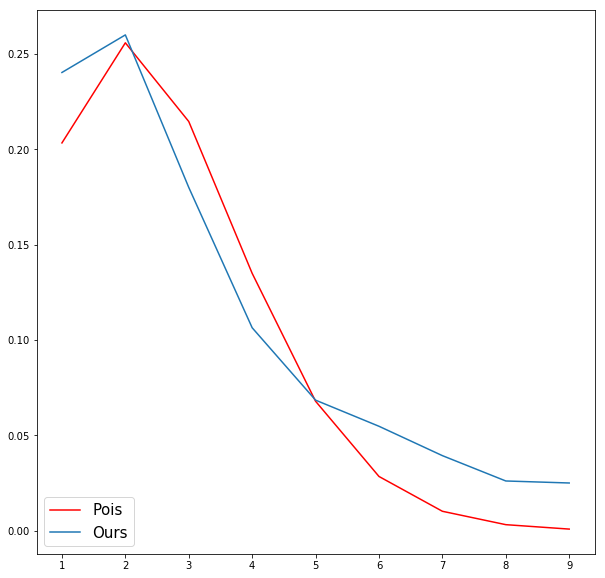

In [70]:
fig = plt.figure(figsize=(10,10))
plt.plot(bins[:-1], pois_pmf[:-1], color='r', label=r'Pois')
plt.plot(bins[:-1], val[0], label=r'Ours')
plt.legend(fontsize=15,loc=3)
plt.show()

In [71]:
import scipy.stats as stats

In [74]:
from scipy.stats import chi2_contingency

In [75]:
import random

In [89]:
h1_res = np.histogram(random.sample(less_5+longer_5, 1000000), bins=[1,2,3,4,5,6,7,9,np.inf])

In [98]:
h2_res = np.histogram(stats.poisson.rvs(mean, size=1000000), bins=[1,2,3,4,5,6,7,9,np.inf])

In [99]:
h1_res

(array([187307, 202539, 140066,  83206,  53411,  42840,  50812,  27041]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   9.,  inf]))

In [100]:
h2_res

(array([202853, 255388, 215219, 134670,  68013,  28604,  13461,   1230]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   9.,  inf]))

In [101]:
stat, p, dof, expected = chi2_contingency([h1_res[0],
                                          h2_res[0]])

In [102]:
print("stat: ", stat)
print("p: ", p)
print("dof: ", dof)
print("expected: ", expected)

stat:  74841.7588199
p:  0.0
dof:  7
expected:  [[ 179967.03240247  211225.55681507  163880.42625362  100498.5061301
    56008.60401486   32954.5946867    29646.86557721   13040.41411998]
 [ 210192.96759753  246701.44318493  191404.57374638  117377.4938699
    65415.39598514   38489.4053133    34626.13442279   15230.58588002]]


In [104]:
for i, num in enumerate(h1_res[0][:-1]):
    print(num/h1_res[0][i+1])

0.924794730891
1.44602544515
1.68336418047
1.55784388984
1.24675536881
0.843107927261
1.87907251951
